In [1]:
import os, shutil
from keras import layers, models, optimizers
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('train.csv')
print(data['label'].value_counts())
data

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


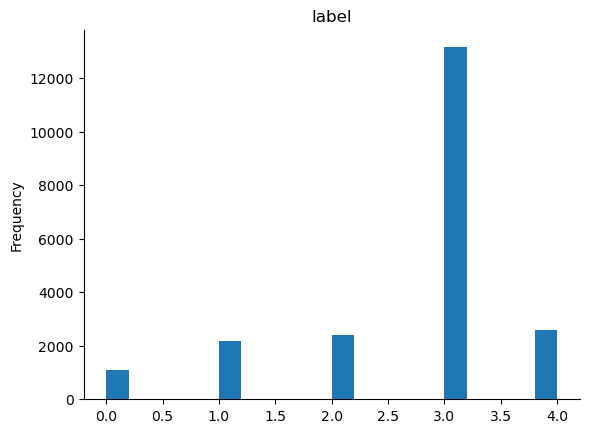

In [3]:
# @title label

from matplotlib import pyplot as plt
data['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [4]:
import random
import warnings
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 21
seed_everything(seed)
warnings.filterwarnings('ignore')

In [5]:
import json
# Importing the json file with labels
with open('label_num_to_disease_map.json') as f:
    real_labels = json.load(f)
    real_labels = {int(k):v for k,v in real_labels.items()}

# Defining the working dataset
data['class_name'] = data['label'].map(real_labels)
data.head()

,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


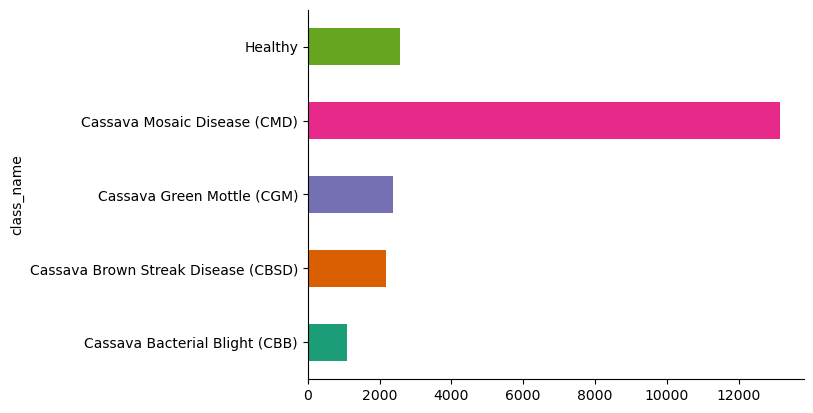

In [6]:
# @title class_name

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('class_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [7]:
from sklearn.model_selection import train_test_split
# generate train and test sets
train, test = train_test_split(data, test_size = 0.3, random_state = 42, stratify = data['class_name'])

In [8]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

In [9]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

datagen_test = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
)

In [10]:
train_set = datagen_train.flow_from_dataframe(
    train,
    directory='train_images',
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = BATCH_SIZE,
)
test_set = datagen_test.flow_from_dataframe(
    test,
    directory='train_images',
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE,
)

Found 14977 validated image filenames belonging to 5 classes.
Found 6420 validated image filenames belonging to 5 classes.


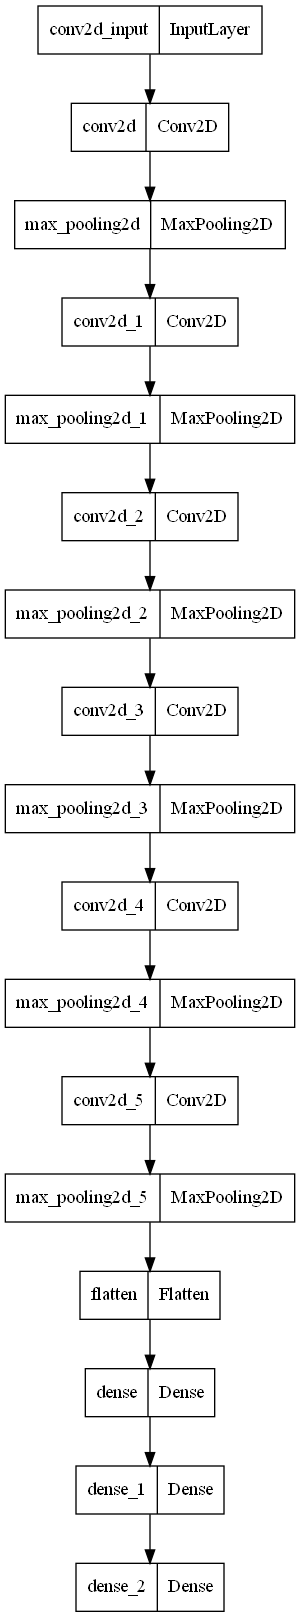

In [11]:
model = models.Sequential([

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape = (IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(n_CLASS, activation = 'softmax')
])

model.build(input_shape = (IMG_SIZE, IMG_SIZE, 3))
from keras.utils import  plot_model

plot_model(model)

In [12]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [13]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [14]:
#Compiling the model
model.compile(loss='categorical_crossentropy', optimizer = get_optimizer(), metrics = ['categorical_accuracy'])
# early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [15]:
#Fitted the model on the training and and validation dataset using the image augmentor for 200 epochs
history = model.fit(train_set,
                    batch_size=BATCH_SIZE,
                    validation_data=test_set,
                    epochs=2,
                    callbacks=[rlrp],
                    verbose = 1)

Epoch 1/2


999/999 [==============================] - 5212s 5s/step - loss: 1.1281 - categorical_accuracy: 0.6212 - val_loss: 0.9528 - val_categorical_accuracy: 0.6438 - lr: 5.0050e-04
Epoch 2/2
999/999 [==============================] - 4015s 4s/step - loss: 0.9362 - categorical_accuracy: 0.6458 - val_loss: 0.8956 - val_categorical_accuracy: 0.6625 - lr: 3.3367e-04


In [16]:
import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten,Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16
model = Sequential()
vgg=VGG16(input_shape = (IMG_SIZE, IMG_SIZE, 3), weights = 'imagenet', include_top = False)
for layer in vgg.layers:
    layer.trainable = False
model.add(vgg)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(n_CLASS, activation = 'softmax'))
model.summary()

58889256/58889256 [==============================] - 9s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 14, 14, 512)       14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 14717253 (56.14 MB)
Trainable params: 2565 (10.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False,
        label_smoothing=0.0001,
        name='categorical_crossentropy'
    )

In [18]:
# Compile the model
model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = loss, #'categorical_crossentropy'
        metrics = ['categorical_accuracy']
    )

In [19]:
es = EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,
        restore_best_weights=True,
        verbose=1,
        )

In [20]:
checkpoint_cb = ModelCheckpoint(
        "Cassava_best_model.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
        )

In [21]:
# Reduce learning rate once learning stagnates
reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1,
        )

In [ ]:
history = model.fit(
        train_set,
        validation_data=test_set,
        epochs=20,
        batch_size=BATCH_SIZE,
        callbacks=[es, checkpoint_cb, reduce_lr],
        )

Epoch 1/20
 83/999 [=>............................] - ETA: 3:53:59 - loss: 1.6413 - categorical_accuracy: 0.5325

In [ ]:
#Part-B


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers, models


# generate train and test sets
X_train,y_train,X_test,y_test = train_test_split(data, test_size = 0.3, random_state = 42, stratify = data['class_name'])

# Define a neural network model


# Function to manipulate labels
def manipulate_labels(label, flip_percentage):
    num_flips = int(len(y_train-) * flip_percentage / 100)
    flip_indices = np.random.choice(len(y_train), num_flips, replace=False)

    for idx in flip_indices:
        current_label = y_train[idx]
        new_label = np.random.randint(0, 5)  # Assuming 5 classes for Cassava Leaf Diseases
        while new_label == current_label:  # Ensure the new label is different from the current one
            new_label = np.random.randint(0, 5)
        y_train[idx] = new_label

    return y_train

# Function to simulate label manipulation and assess impact
def simulate_label_manipulation(X_train, y_train, X_test, y_test, flip_percentages):
    original_accuracy = train_and_evaluate(X_train, y_train, X_test, y_test)
    manipulated_accuracies = []

    for flip_percentage in flip_percentages:
        y_train_manipulated = manipulate_labels(np.copy(y_train), flip_percentage)
        accuracy = train_and_evaluate(X_train, y_train_manipulated, X_test, y_test)
        manipulated_accuracies.append(accuracy)

    return original_accuracy, manipulated_accuracies

# Main function to run experiments
def main():
    # Assuming data is loaded and preprocessed
    # X_train, y_train, X_test, y_test = ...

    # Define percentages of flipped labels
    flip_percentages = [5, 10, 15, 20, 25]

    # Simulate label manipulation and assess impact
    original_accuracy, manipulated_accuracies = simulate_label_manipulation(X_train, y_train, X_test, y_test, flip_percentages)

    # Plot results
    plt.plot(flip_percentages, manipulated_accuracies, marker='o')
    plt.xlabel('Percentage of Flipped Labels')
    plt.ylabel('Accuracy')
    plt.title('Impact of Label Manipulation on Model Performance')
    plt.xticks(flip_percentages)
    plt.axhline(y=original_accuracy, color='r', linestyle='--', label='Original Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
    